In [17]:
import gzip
import json
import pandas as pd
import numpy as np
from os.path import join, isfile
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 150

In [39]:
def get_json(fname, fpath='../../wos_paper/wos_db_benchmark/benchmarking/'):
    fname = join(fpath, fname)
    with open(fname, 'r') as fp:
        data = json.load(fp)
    return data

def get_json_fnames(sourcepath='../../wos_paper/wos_db_benchmark/benchmarking/'):
    only_json = [f for f in listdir(sourcepath) if 
                     isfile(join(sourcepath, f)) 
                     and f[-4:] == 'json']
    return only_json

def get_content(sql_list, fpath, how='sql'):
    report = []
    if how == 'sql':
        limit_tokens = 3
    elif how == 'arango':
        limit_tokens = 3
    else:
        limit_tokens = 3
    for f in sql_list:
        coded = f.split('_')
        limit = -1 if len(coded) < limit_tokens else int(coded[-1].split('.')[0])
        content = get_json(f, fpath)
        report += [(coded[0], limit, f, content)]
    return report

def get_mysql_times(sql_report):
    times_stat = []
    for item in sql_report:
        key, limit, f, content = item
        if 'elapsed' in content:
            times_stat += [(*item[:-1], content['elapsed'])]
        else:
            times_stat += [(*item[:-1], content['elapsed_1978'])]
    return times_stat

def get_arango_times(reports):
    times = [(*item[:-1], [sum(x.values()) for x in item[-1]]) for item in reports]
#     times_stat = [(*item[:-1], np.mean(item[-1]), np.std(item[-1])) for item in times]
    times_stat = [(*item[:-1], item[-1]) for item in times]
    return times_stat

In [40]:
sql_list = sorted(get_json_fnames())
sql_report = get_content(sql_list, '../../wos_paper/wos_db_benchmark/benchmarking/')
sql_times = get_mysql_times(sql_report)
sql_times[:4]

[('query1', -1, 'query1_results.json', 5.173050403594971),
 ('query1', 125, 'query1_results_125.json', 12.609336137771606),
 ('query2', -1, 'query2_results.json', 100.15733695030212),
 ('query3', -1, 'query3_results.json', 838.3496978282928)]

In [41]:
arango_list = sorted(get_json_fnames('../results/arango/'))
arango_report = get_content(arango_list, '../results/arango/')
arango_times = get_arango_times(arango_report)
arango_times[:3]

[('query1',
  -1,
  'query1_profile.json',
  [102.44689583778381, 103.04237246513367, 101.88763976097107]),
 ('query1',
  10,
  'query1_profile_limit_10.json',
  [0.0008015632629394531, 0.0007097721099853516, 0.0007927417755126953]),
 ('query1',
  1280,
  'query1_profile_limit_1280.json',
  [15.631070375442505, 7.661109447479248, 3.826685667037964])]

In [66]:
dfa = pd.DataFrame(arango_times, columns=['query', 'limit', 'fname', 's']).sort_values(['query', 'limit'])
dfs = pd.DataFrame(sql_times, columns=['query', 'limit', 'fname', 's']).sort_values(['query', 'limit'])

In [67]:
dfa.head()

,query,limit,fname,s
0,query1,-1,query1_profile.json,"[102.44689583778381, 103.04237246513367, 101.8..."
8,query1,5,query1_profile_limit_5.json,"[0.0009133815765380859, 0.0006301403045654297,..."
1,query1,10,query1_profile_limit_10.json,"[0.0008015632629394531, 0.0007097721099853516,..."
4,query1,20,query1_profile_limit_20.json,"[0.02542400360107422, 0.00959014892578125, 0.0..."
7,query1,40,query1_profile_limit_40.json,"[0.040454864501953125, 0.02847146987915039, 0...."


In [68]:
data = []

for item in dfa.itertuples():
    lst = item[-1]
    for x in lst:
        data.append(list(item[1:-1]) + [x])

dfau = pd.DataFrame(data, columns=dfa.columns)
dfau.head()

,query,limit,fname,s
0,query1,-1,query1_profile.json,102.446896
1,query1,-1,query1_profile.json,103.042372
2,query1,-1,query1_profile.json,101.887640
3,query1,5,query1_profile_limit_5.json,0.000913
4,query1,5,query1_profile_limit_5.json,0.000630


In [69]:
dfa_ref = dfau[dfau.limit == -1].copy()
dfa_bench = dfau[dfau.limit != -1].copy()

In [70]:
# df0 = pd.merge(dfs[['query', 'limit', 'delta']], dfa[['query', 'limit', 'delta']], 
#          how='inner', on=['query', 'limit'], suffixes=['_sql', '_arango']).sort_values(['query', 'limit'])

In [71]:
# df0

In [72]:
# df00 = pd.merge(dfs[['query', 'limit', 'delta']], dfa[['query', 'limit', 'delta']], 
#          how='outer', on=['query', 'limit'], suffixes=['_sql', '_arango']).sort_values(['query', 'limit'])

In [63]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [79]:
dfs_ref = dfs[dfs.limit == -1].copy()
dfs_bench = dfs[dfs.limit != -1].copy()

bdict = dict(dfa_bench[['query', 's']].values)
bdict_sql = dict(dfs_ref[['query', 's']].values)

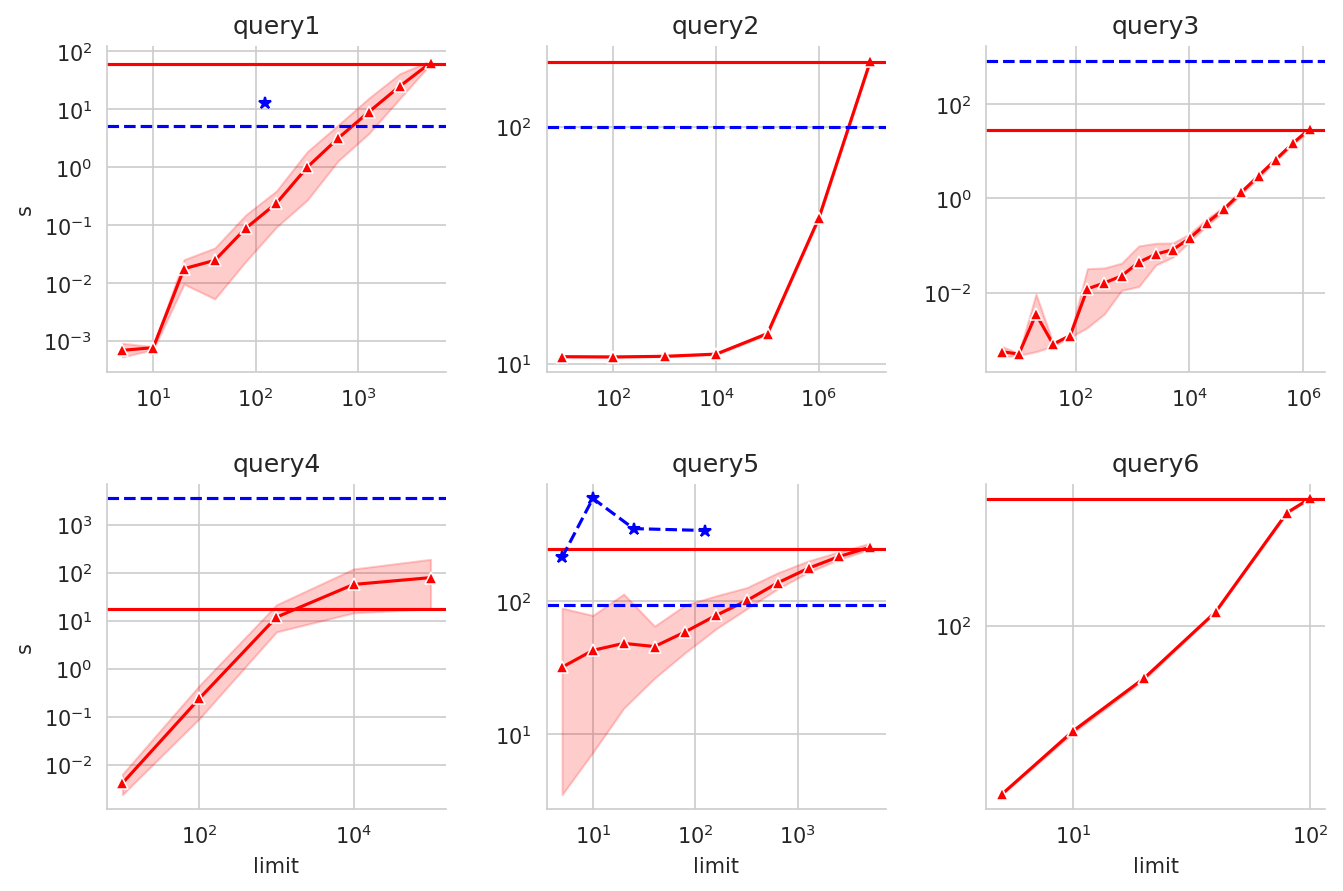

In [112]:
g = sns.FacetGrid(dfa_bench, col='query', sharex=False, sharey=False, 
                  col_wrap=3, margin_titles=True)
sns.set_style("whitegrid")
g.map(sns.lineplot, 'limit', 's', marker="^", color="r").set(yscale='log').set(xscale='log')
# g.map(sns.lineplot, 'limit', 's').set(xscale='log')
for j, ax in enumerate(g.axes):
    cq = f"query{j+1}"
    ax.axhline(bdict[cq], c='r')
    ax.set_title(cq)
    
    mask_sql_bench = (dfs_bench["query"] == cq)
    if sum(mask_sql_bench) > 0:
        x, y = dfs_bench.loc[mask_sql_bench, ["limit", "s"]].sort_values("limit").values.T
        ax.plot(x, y, c="b", marker="*", linestyle="dashed")
    if cq in bdict_sql:
        ax.axhline(bdict_sql[cq], c='b', linestyle="dashed")
plt.savefig("./queries_plot_times.png", dpi=200)